<img src='img/logo.png' alt='Drawing' style='width:2000px;'/>
<img src='img/_logo.JPG' alt='Drawing' style='width:2000px;'/>

# <font color=blue>4.2 Moment Curvature Analysis</font>

In this example, a moment-curvature analysis of the fiber section is undertaken using [OpenSeesPy](https://openseespydoc.readthedocs.io/en/latest/index.html)
<img src="img/MPhi1.png" width="400" >

## <font color=blue>Model</font>

The model consists of two nodes and a ZeroLengthSection element. A depiction of the element geometry is shown in the figure . The drawing on the left of the figure shows an edge view of the element where the local z-axis, as seen on the right side of the previous figure, is coming out of the page. Node 1 is completely restrained, while the applied loads act on node 2. A compressive axial load, P, of 180 kips is applied to the section during the moment-curvature analysis.

For the zero length element, a section discretized by concrete and steel is created to represent the resultant behavior. UniaxialMaterial objects are created to define the fiber stress-strain relationships: confined concrete in the column core, unconfined concrete in the column cover, and reinforcing steel.

The dimensions of the fiber section are shown in the figure. The section depth is 24 inches, the width is 15 inches, and there are 1.5 inches of cover around the entire section. Strong axis bending is about the section z-axis. In fact, the section z-axis is the strong axis of bending for all fiber sections in planar problems. The section is separated into confined and unconfined concrete regions, for which separate fiber discretizations will be generated. Reinforcing steel bars will be placed around the boundary of the confined and unconfined regions. The fiber discretization for the section is shown in the figure.

<img src="img/MPhi2.png" width="400" >
<img src="img/MPhi3.png" width="400" >

## <font color=blue>Material</font>
Among many different [uniaxial material](https://openseespydoc.readthedocs.io/en/latest/src/uniaxialMaterial.html) models
In this example, for concrete model we are going to use [concrete01](https://openseespydoc.readthedocs.io/en/latest/src/Concrete01.html). It is Kent-Scott-Park concrete material with degraded linear unloading/reloading stiffness according to the work of Karsan-Jirsa and no tensile strength.
<img src="img/Concrete01.jpg" width="400" >

For steel model, we are going to use [steel01](https://openseespydoc.readthedocs.io/en/latest/src/steel01.html). It is a  bilinear steel material with kinematic hardening and optional isotropic hardening described by a non-linear evolution equation.

<img src="img/Steel01.jpg" width="400" >

In [4]:
#  ----------------------
#  LIBRARIES
#  ----------------------

import openseespy.opensees as ops
import matplotlib.pyplot as plt

#  -----------------------------------------
#  DEFINITION OF MOMENT CURVATURE ANALYSIS
#  -----------------------------------------

def MomentCurvature(secTag, axialLoad, maxK, numIncr=100):
    
    # Define two nodes at (0,0)
    ops.node(1, 0.0, 0.0)
    ops.node(2, 0.0, 0.0)

    # Fix all degrees of freedom except axial and bending
    ops.fix(1, 1, 1, 1)
    ops.fix(2, 0, 1, 0)
    
    # Define element
    #                             tag ndI ndJ  secTag
    ops.element('zeroLengthSection',  1,   1,   2,  secTag)

    # Define constant axial load
    ops.timeSeries('Constant', 1)
    ops.pattern('Plain', 1, 1)
    ops.load(2, axialLoad, 0.0, 0.0)

    # Define analysis parameters
    ops.integrator('LoadControl', 0.0)
    ops.system('SparseGeneral', '-piv')
    ops.test('NormUnbalance', 1e-9, 10)
    ops.numberer('Plain')
    ops.constraints('Plain')
    ops.algorithm('Newton')
    ops.analysis('Static')

    # Do one analysis for constant axial load
    ops.analyze(1)

    # Define reference moment
    ops.timeSeries('Linear', 2)
    ops.pattern('Plain',2, 2)
    ops.load(2, 0.0, 0.0, 1.0)

    # Compute curvature increment
    dK = maxK / numIncr

    # Use displacement control at node 2 for section analysis
    ops.integrator('DisplacementControl', 2,3,dK,1,dK,dK)

    # Do section analysis
    Phi = [0]        # list to store curvature results
    M = [0]       # list to store moment results
    for ii in range(numIncr): 
        ok = ops.analyze(1)
        Phi.append(ops.nodeDisp(2,3))
        M.append(ops.getLoadFactor(2))
        if ok != 0:
            break
            
    return Phi, M
    

In [5]:
#  ------------------------
#  DEFINITION OF UNITS
#  ------------------------

# Basic Units
m = 1.0
kN = 1.0
sec = 1.0

# Length
mm = m / 1000.0
cm = m / 100.0
inch = 25.4 * mm
ft = 12.0 * inch

# Force
N = kN / 1000.0
kip = kN * 4.448221615

# Mass (tonnes)
tonne = kN * sec ** 2 / m
kg = N * sec ** 2 / m

# Stress (kN/m2 or kPa)
Pa = N / (m ** 2)
kPa = Pa * 1.0e3
MPa = Pa * 1.0e6
GPa = Pa * 1.0e9
ksi = 6.8947573 * MPa
psi = 1e-3 * ksi

Estimated yield curvature: 0.0073


after: 10 iterations  current Norm: 3.77347 (max: 1e-09, Norm deltaX: 5.15062e-05)
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 376.811
OpenSees > analyze failed, returned: -3 error flag


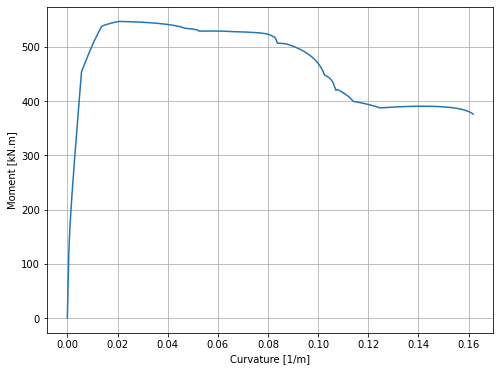

In [6]:
#  ------------------------
#  DEFINITION OF MODEL
#  ------------------------

# Wipe any existing model
# -----------------------
ops.wipe()

# Define model builder
# --------------------
ops.model('basic','-ndm',2,'-ndf',3)

# Define materials for nonlinear columns
# --------------------------------------
# CONCRETE                        tag   f'c        ec0      f'cu   ecu
# Core concrete (confined)
ops.uniaxialMaterial('Concrete01', 1,  -6.0*ksi,  -0.004,  -5.0,  -0.014)

# Cover concrete (unconfined)
ops.uniaxialMaterial('Concrete01', 2,  -5.0*ksi,  -0.002,   0.0,  -0.006)

# STEEL
# Reinforcing steel 
fy = 60.0*ksi      # Yield stress
E = 30000.0*ksi    # Young's modulus

#                              tag  fy  E0    b
ops.uniaxialMaterial('Steel01', 3,  fy, E,    0.01)

# Define cross-section for nonlinear columns
# ------------------------------------------

# set some paramaters
colWidth = 15*inch
colDepth = 24*inch 

cover = 1.5*inch
As = 0.60*inch**2     # area of no. 7 bars

# some variables derived from the parameters
y1 = colDepth/2.0
z1 = colWidth/2.0

# Start definitiona fiber section with Tag 1
ops.section('Fiber', 1)

# Create the concrete core fibers
ops.patch('rect',1,10,1 ,cover-y1, cover-z1, y1-cover, z1-cover)

# Create the concrete cover fibers (top, bottom, left, right)
ops.patch('rect',2,10,1 ,-y1, z1-cover, y1, z1)
ops.patch('rect',2,10,1 ,-y1, -z1, y1, cover-z1)
ops.patch('rect',2,2,1 ,-y1, cover-z1, cover-y1, z1-cover)
ops.patch('rect',2,2,1 ,y1-cover, cover-z1, y1, z1-cover)

# Create the reinforcing fibers (left, middle, right)
ops.layer('straight', 3, 3, As, y1-cover, z1-cover, y1-cover, cover-z1)
ops.layer('straight', 3, 2, As, 0.0     , z1-cover, 0.0     , cover-z1)
ops.layer('straight', 3, 3, As, cover-y1, z1-cover, cover-y1, cover-z1)

# Estimate yield curvature
# (Assuming no axial load and only top and bottom steel)
# d -- from cover to rebar
d = colDepth-cover
# steel yield strain
epsy = fy/E
Ky = 2.1*epsy/(d)

# Print estimate to standard output
print("Estimated yield curvature: %.4f" % Ky)

# Set axial load 
P = -180.0*kip

# Target ductility for analysis
mu = 30

# Number of analysis increments
numIncr = 2000

# Call the section analysis procedure
Phi, M = MomentCurvature(1, P, Ky*mu, numIncr)

# Lets plot the results
plt.figure(figsize=[8,6])
plt.plot(Phi, M)
plt.grid(True)
plt.xlabel('Curvature [1/m]')
plt.ylabel('Moment [kN.m]')
plt.show()

There are people who develops visualization tools for openseespy as well. If you are interested explore github.com a bit. Christian does very good job who recently contacted me for this purpose. Look at some of his [material](https://github.com/cslotboom/OpenSeesPyTutorials). 